PBC

In [ ]:
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

In [84]:
N = 4
J = get_jmat_pbc(N, 0.5)
J

array([[0.        , 1.        , 0.70710678, 1.        ],
       [1.        , 0.        , 1.        , 0.70710678],
       [0.70710678, 1.        , 0.        , 1.        ],
       [1.        , 0.70710678, 1.        , 0.        ]])

## Periodic Boundary Condition

## TFIM + Sx
Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[\sum_{ij}\hat{\sigma}^x_i \hat{\sigma}^x_j + h \cos(\omega t)\sum_i \hat{\sigma}^z_i + \sum_i  \hat{\sigma}^x_i\Bigg]
\end{equation}

# XXZ + Sx
Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[J\sum_{ij} (\hat{\sigma}^x_i \hat{\sigma}^x_j +\hat{\sigma}^y_i \hat{\sigma}^y_j)+ \Delta\hat{\sigma}^z_i \hat{\sigma}^z_j+ h \cos(\omega t)\sum_i \hat{\sigma}^z_i + \sum_i \hat{\sigma}^x_i\Bigg]
\end{equation}

In [2]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm


##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return  h * np.cos(w * t)

def get_hamiltonian(N,beta):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H21, H22, H23=  empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) 
    
    return 0.5*H21, 0.5*H22, 0.5*H23

##-- Dynamics

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']    
    H21, H22, H23 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive], H23]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

#----------xxz+sx

def get_hamiltonian_xxzsx(N, beta, del_an):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H11, H12, H13, H21, H22 =  empt, empt, empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H11 = H11 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
    
    comb = combinations(np.arange(N), 2)    
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id, tensor(sy, tensor(id1,tensor(sy,id2)))).full()) * jmat[i,j]
        
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H13 = H13 + Qobj(tensor(id, tensor(sz, tensor(id1,tensor(sz,id2)))).full()) * jmat[i,j] * del_an
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H21 = H21 + Qobj(tensor(id,tensor(sz,id1)).full())
    
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sx,id1)).full())
    
    return 0.5*H11, 0.5*H12, 0.5*H13, 0.5*H21, 0.5*H22

##-- Dynamics
def run_dynm_corr_avg_xxz(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']    
    H11, H12, H13, H21, H22 =  get_hamiltonian_xxzsx(N, beta, del_an)
    
    params = args
    H = [H11,H12,H13,[H21,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)


def run_dynm_corr_avg_xxzsx(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']    
    H11, H12, H13, H21, H22 =  get_hamiltonian_xxzsx(N, beta, del_an)
    
    params = args
    H = [H11,H12,H13,[H21,drive], H22]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

TFIM + sx done !
xxz done !

Now plotting...


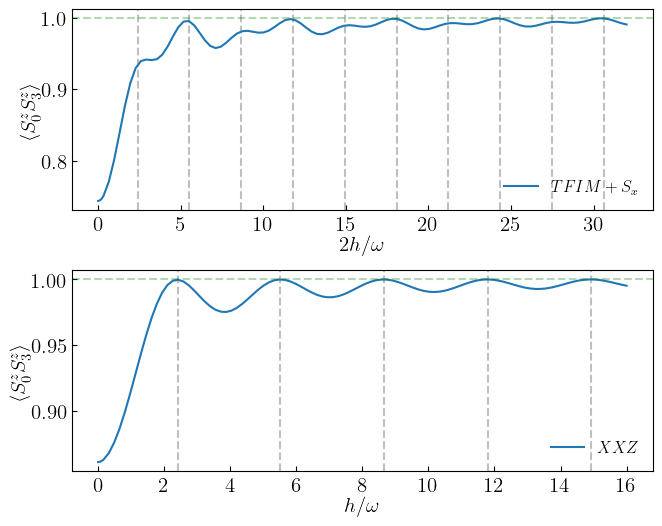

CPU times: user 722 ms, sys: 152 ms, total: 873 ms
Wall time: 11.7 s


In [7]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

fig, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.00, hspace=0.3)

N = 4
omega = 90
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 10 * T, 50, endpoint=False)
beta = float('inf')
pos1 = 0
pos2 = 2

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,32, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

for i,xx in enumerate(jn_zeros(0,10)):
    ax1.axvline(x=xx, alpha=0.25, color = 'black', linestyle = '--')



i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)
print('TFIM + sx done !')

ax1.plot(2*hs/w, data, label = r"$TFIM + S_x$")

##-----------xxz+sx
del_an = 0.5
sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

hss = w * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data1 = p.map(run_dynm_corr_avg_xxzsx,param)
print('xxz done !\n\nNow plotting...')


for i,xx in enumerate(jn_zeros(0,5)):
    ax2.axvline(x=xx, alpha=0.25, color = 'black', linestyle = '--')

ax2.plot(hs/w, data1, label = r"$XXZ$")     

ax1.set_ylabel(r"$ \langle S^z_0 S^z_3\rangle$", labelpad=0)
ax1.set_xlabel(r"$2h/\omega$", labelpad=0)
ax2.set_ylabel(r"$ \langle S^z_0 S^z_3\rangle$", labelpad=0)
ax2.set_xlabel(r"$h/\omega$", labelpad=0)

ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")

ax1.axhline(y=1.0, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=1.0, color='green', alpha=0.3, linestyle='--')

ax1.legend(frameon=False, fontsize=12, loc=4)
ax2.legend(frameon=False, fontsize=12, loc=4)

#plt.savefig('corrN8sz0sz3avg_tfim_sx_xxz.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
#plt.savefig('corrN8sz0sz3avg_tfim_sx_xxz.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)

plt.show()

TFIM + sx done !
xxz done !

Now plotting...


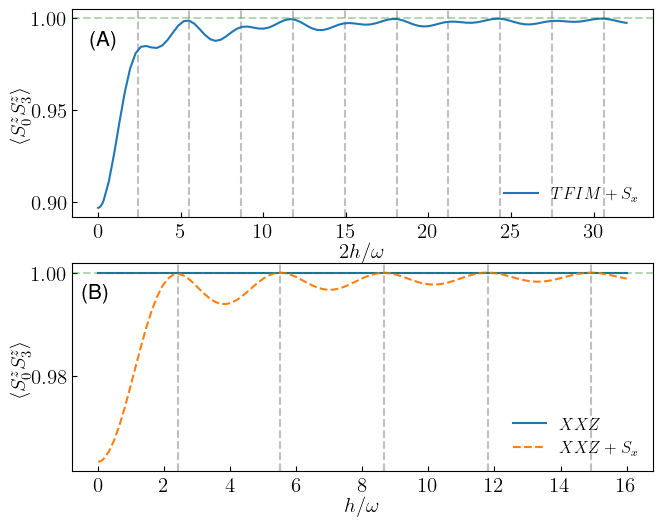

CPU times: user 1.97 s, sys: 247 ms, total: 2.22 s
Wall time: 1min 5s


In [21]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

fig, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.00, hspace=0.22)

N = 8
omega = 90
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 5 * T, 20, endpoint=False)
beta = float('inf')
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,32, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

for i,xx in enumerate(jn_zeros(0,10)):
    ax1.axvline(x=xx, alpha=0.25, color = 'black', linestyle = '--')



i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)
print('TFIM + sx done !')

ax1.plot(2*hs/w, data, label = r"$TFIM + S_x$")

##-----------xxz+sx
del_an = 0.5
sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

hss = w * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]
data0 = p.map(run_dynm_corr_avg_xxz,param)
data1 = p.map(run_dynm_corr_avg_xxzsx,param)

print('xxz done !\n\nNow plotting...')

for i,xx in enumerate(jn_zeros(0,5)):
    ax2.axvline(x=xx, alpha=0.25, color = 'black', linestyle = '--')

ax2.plot(hs/w, data0, label = r"$XXZ$")       
ax2.plot(hs/w, data1, label = r"$XXZ+S_x$", linestyle='--')     

ax1.set_ylabel(r"$ \langle S^z_0 S^z_3\rangle$", labelpad=0)
ax1.set_xlabel(r"$2h/\omega$", labelpad=0)
ax2.set_ylabel(r"$ \langle S^z_0 S^z_3\rangle$", labelpad=0)
ax2.set_xlabel(r"$h/\omega$", labelpad=0)

ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")

ax1.axhline(y=1.0, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=1.0, color='green', alpha=0.3, linestyle='--')

ax1.legend(frameon=False, fontsize=12, loc=4)
ax2.legend(frameon=False, fontsize=12, loc=4)

ax1.text(-0.5, .985,'(A)')
ax2.text(-0.5, .995,'(B)')

plt.savefig('corrN8sz0sz3avg_tfim_sx_xxz_sx.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_tfim_sx_xxz_sx.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)

plt.show()